In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sktime.utils.plotting import plot_series as ploting_series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Things to process in data 

Reports null for 20 min every week, So that 20 their would be a jump observed of 40 minutes in the data

Data only from 5am to 11:59pm 

More demand on Holiday =>  seasonality in data we need to remove by differencing

All those number plate differe by one character are same 

In [2]:
# Function to calculate MASE (Mean Absolute Scaled Error)
def mase(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)[1:]
    mae_naive = np.mean(np.abs(y_train[1:] - naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / mae_naive


In [3]:
# Function to calculate MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [4]:
# Function to plot the time series
def plot_series(train, test, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label="Train Data")
    plt.plot(test.index, test, label="Test Data", color='orange')
    plt.plot(test.index, forecast, label="Forecast", color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [5]:
# Function to plot ACF and PACF in a 1x2 subplot
def plot_acf_pacf(data, lags):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    plot_acf(data, lags=lags, ax=ax[0])
    ax[0].set_title('Autocorrelation (ACF)')
    
    plot_pacf(data, lags=lags, ax=ax[1])
    ax[1].set_title('Partial Autocorrelation (PACF)')
    
    plt.tight_layout()
    plt.show()

In [6]:
# Load the parking lot data
df = pd.read_csv('./parkingLot.csv')
# Droping those values where camera didn't worked
# So make a dict of the day camera didn't worked and number of cars passed by during that time in order to update the vehicles per day 

# Now processing the data
df['timestamp'] = pd.to_datetime(df['timestamp'])

# It was observed that the Entries with and without filtering of operational hours were the same, so it was decided to not filter the data
# Beacuse only vehicles were exiting during non - operational hours and that would be helpful to find the avg time spent by a vehicle on a particular day , Also accounting for them would give the true number of vehicles entering per day 

df_entry = df[df['camera_id'] == 1].copy()
vehicles_per_day = df_entry.groupby(df_entry['timestamp'].dt.date).size().asfreq('D')
vehicles_per_day.index.name = 'date'
# Now ignoring the nan values , as we dont have car number for them
# Now for the vehicles that dont have the either entry or exit time they are dropped , beacuse those'd vehicles other half i.e. exit or entry is marked during the maintenance time, So we can't find thier exact tie of leaving . 
df = df.dropna(subset=['vehicle_no'])

df_entry = df[df['camera_id'] == 1].copy().rename(columns={'timestamp': 'timestamp_entry'})
df_exit = df[df['camera_id'] == 2].copy().rename(columns={'timestamp': 'timestamp_exit'})

# Merge entry and exit data based on nearest timestamp match within each vehicle group
merged_data = pd.merge_asof(
    df_entry,
    df_exit,
    by='vehicle_no',
    left_on='timestamp_entry',
    right_on='timestamp_exit',
    direction='forward'  # Matches entry with the nearest future exit
)
# Remove rows with missing entries or exits
merged_data.dropna(subset=['timestamp_entry', 'timestamp_exit'], inplace=True)
# Calculate time spent in minutes
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 60
# Calculate average time spent per day
avg_time_per_day = merged_data.groupby(merged_data['timestamp_entry'].dt.date)['time_spent'].mean()
avg_time_per_day.index.name = 'date'

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Vehicles Entering Per Day (Diff 7)'}>)

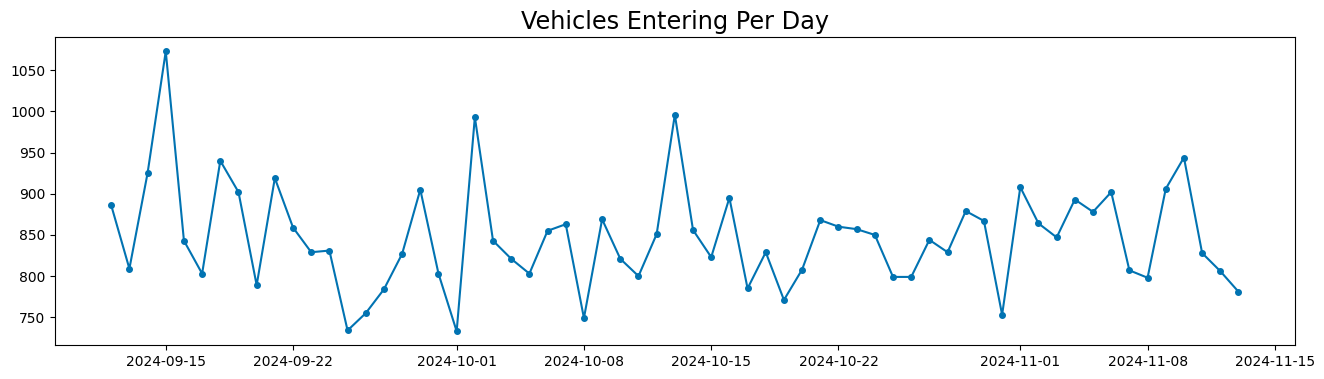

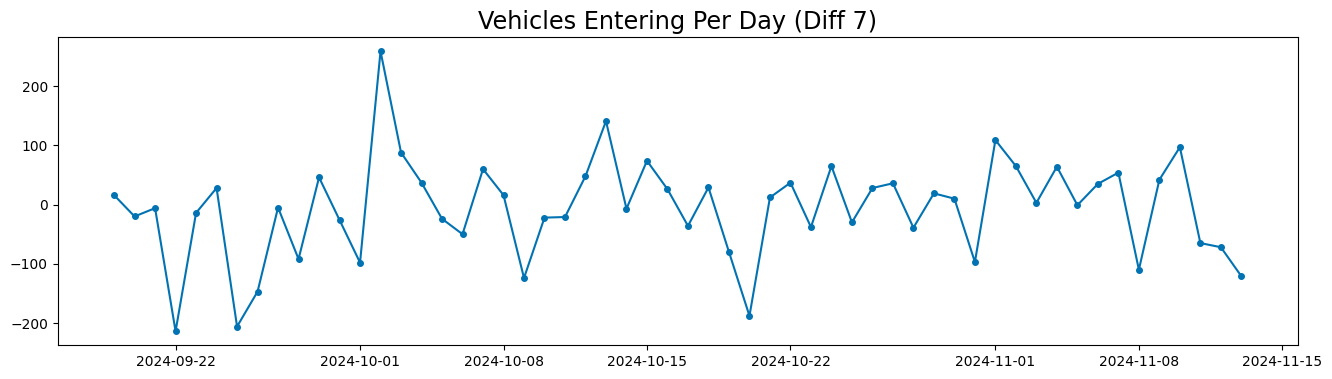

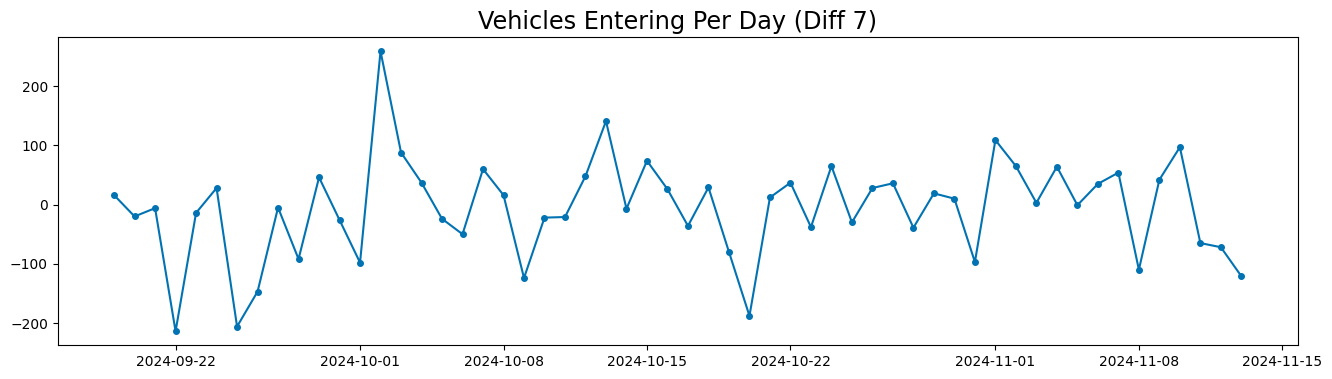

In [8]:
ploting_series(vehicles_per_day, title="Vehicles Entering Per Day")
vehicles_per_day_diff = vehicles_per_day.diff(periods=7).dropna()
# Now the plot of vehicles per day diff shows that the data is somehwat stationary , however we need further differencing to make it stationary
# Only applying d=2  we get a stationary data
vehicles_per_day_stationary = vehicles_per_day_diff.dropna()
ploting_series(vehicles_per_day_diff, title="Vehicles Entering Per Day (Diff 7)")
ploting_series(vehicles_per_day_stationary, title="Vehicles Entering Per Day (Diff 7)")

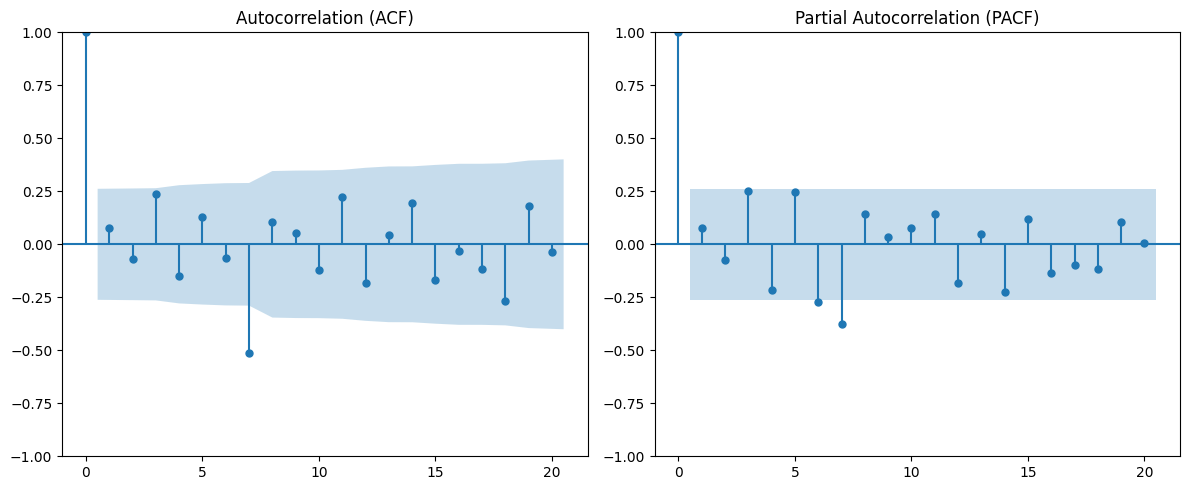

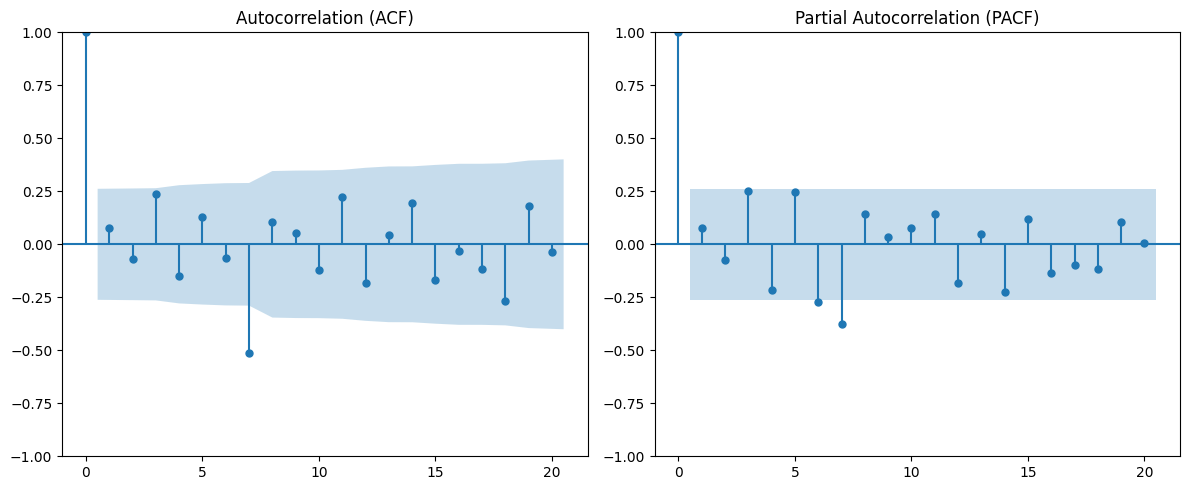

In [9]:
# Plotting ACF and PACF
plot_acf_pacf(vehicles_per_day_stationary, lags=20)
plot_acf_pacf(vehicles_per_day_diff, lags=20)


In [10]:
# Split data into training and testing sets
train_size = int(len(vehicles_per_day) * 0.8)
train_data, test_data = vehicles_per_day[:train_size], vehicles_per_day[train_size:]

# Ensure the index has a frequency for ARIMA
train_data.index = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='D')
test_data.index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=len(test_data), freq='D')

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters 

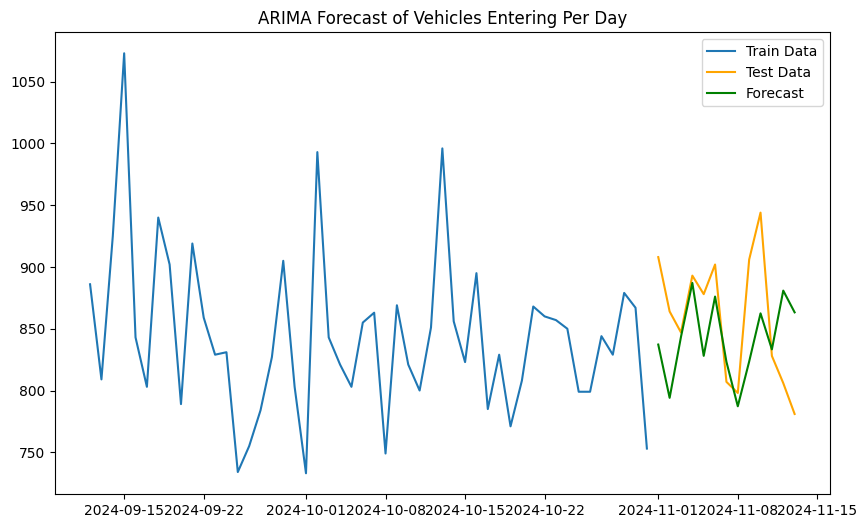

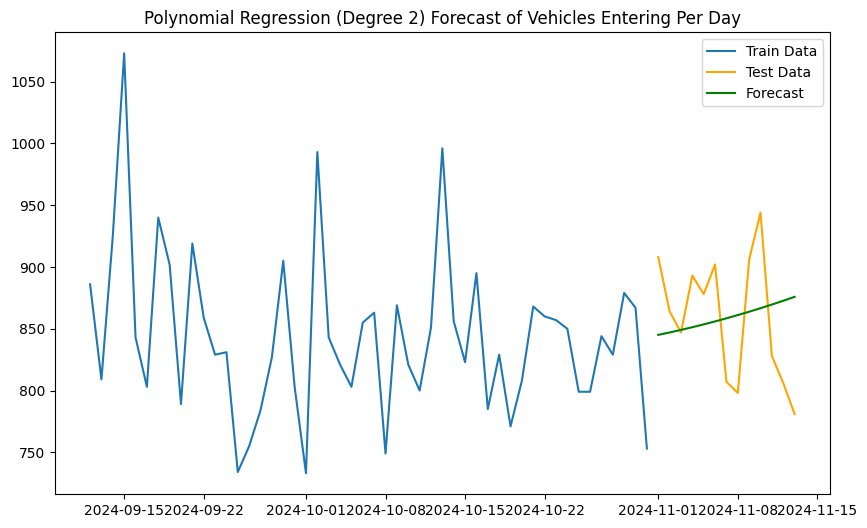

Part A: Forecast Total Number of Vehicles Entering Per Day
ARIMA MASE: 0.6371053936955103
ARIMA MAPE: 5.162176601186677
Polynomial Regression (Degree 2) MASE: 0.6941080774666484
Polynomial Regression (Degree 2) MAPE: 5.7138348822523515


In [11]:
# ARIMA model for forecasting vehicles entering
mape_min = 100
best_p = 0  
best_q = 0
best_d = 0
for d in range(0,2) : 
    for p in range(0,6) : 
        for q in range(0,6) : 
            arima_model = ARIMA(train_data, order=(p, d, q) , seasonal_order=(1,1,1,7))
            arima_result = arima_model.fit()
            arima_forecast = arima_result.forecast(steps=len(test_data))
            mape_val = mape(test_data, arima_forecast)
            if mape_val < mape_min : 
                mape_min = mape_val
                best_p = p
                best_q = q
                best_d = d

arima_model = ARIMA(train_data, order=(best_p, best_d, best_q) , seasonal_order=(1,1,1,7))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))


# Polynomial Regression for forecasting vehicles entering
degree = 2  # You can change the degree of the polynomial
X_train = np.arange(len(train_data)).reshape(-1, 1)
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, train_data)
poly_forecast = poly_model.predict(X_test)

# Plot ARIMA forecast
plot_series(train_data, test_data, arima_forecast, "ARIMA Forecast of Vehicles Entering Per Day")

# Plot Polynomial Regression forecast
plot_series(train_data, test_data, poly_forecast, f"Polynomial Regression (Degree {degree}) Forecast of Vehicles Entering Per Day")

# Evaluate models for Part A
print("Part A: Forecast Total Number of Vehicles Entering Per Day")
print("ARIMA MASE:", mase(test_data, arima_forecast, train_data))
print("ARIMA MAPE:", mape(test_data.values, arima_forecast.values))
print(f"Polynomial Regression (Degree {degree}) MASE:", mase(test_data, poly_forecast, train_data))
print(f"Polynomial Regression (Degree {degree}) MAPE:", mape(test_data, poly_forecast))

In [7]:
def forecast_arima(model_fit,test_len):
    forecast= model_fit.forecast(steps=test_len+1)
    forecast.sort_index(inplace=True)
    return forecast

In [8]:
def plot_forecasted_Data(data,months_to_predict,model_fit) :
    forecasted_data = forecast_arima(model_fit,months_to_predict)
    # Plotting for visualization of the forecasted data 
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data, label='Train', color='blue')
    plt.plot(forecasted_data.index, forecasted_data, label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast vs Actual')
    plt.show()
    return forecasted_data

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


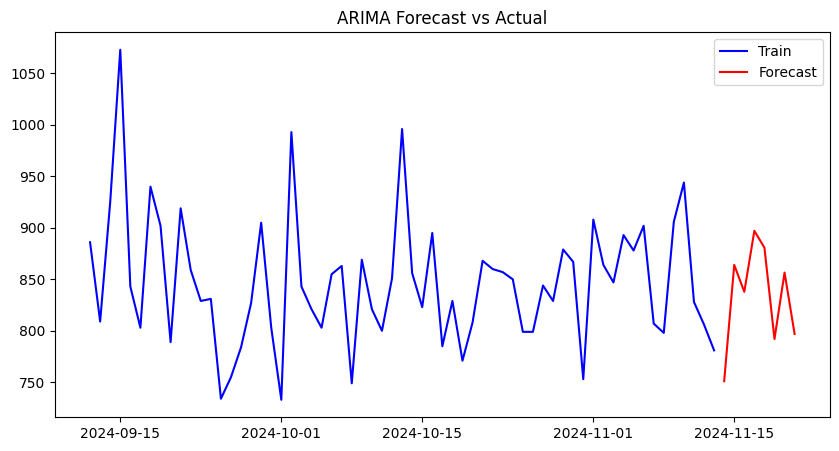

2024-11-14    751.055077
2024-11-15    864.020670
2024-11-16    837.869972
2024-11-17    897.135520
2024-11-18    880.731288
2024-11-19    792.040842
2024-11-20    856.569116
2024-11-21    796.892494
Freq: D, Name: predicted_mean, dtype: float64


In [14]:
model_fit = ARIMA(vehicles_per_day, order=(best_p, best_d, best_q) , seasonal_order=(1,1,1,7)).fit()
forecasted_data = plot_forecasted_Data(vehicles_per_day,7,model_fit)
print(forecasted_data)

In [15]:
# Forecasting for the average time spent by a vehicle
pd.options.display.max_rows = None
pd.options.display.max_columns = None

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


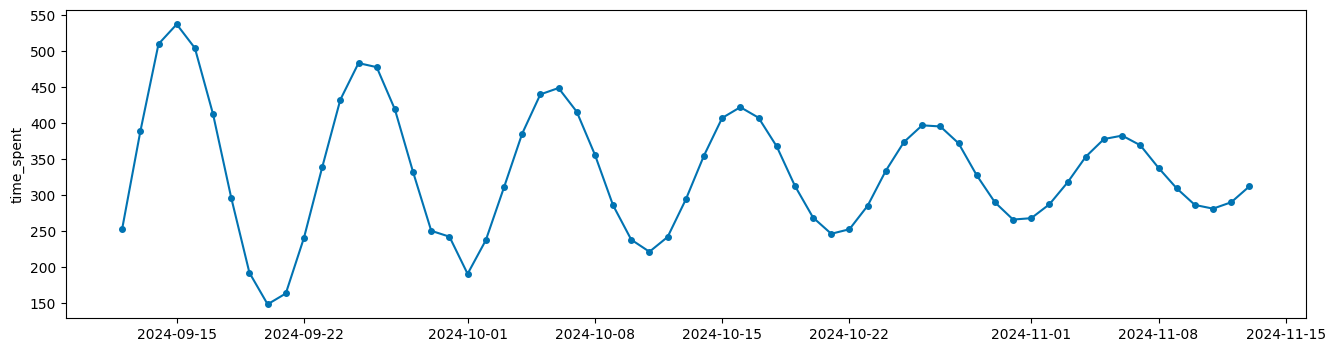

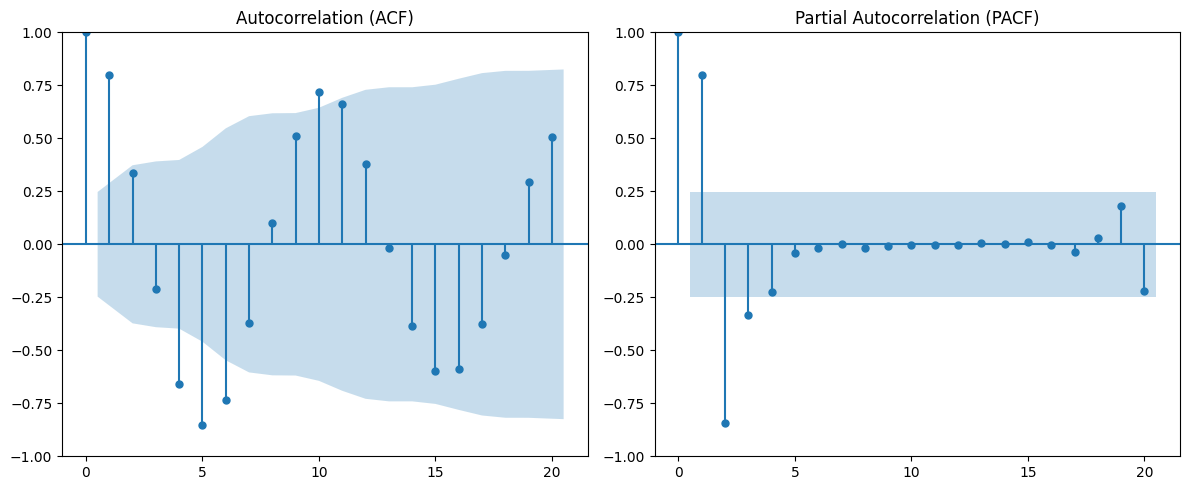

In [9]:
avg_time_per_day.index = pd.to_datetime(avg_time_per_day.index)
ploting_series(avg_time_per_day)
plot_acf_pacf(avg_time_per_day, lags=20)

A clear downward trend along cycle is obsereved 

And this cycle is weekly , So plot the diff = 10 , for it to check for stationarity

In [25]:
# Split data into training and testing sets
train_size = int(len(avg_time_per_day) * 0.8)
train_data, test_data = avg_time_per_day[:train_size], avg_time_per_day[train_size:]

# Ensure the index has a frequency for ARIMA
train_data.index = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='D')
test_data.index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=len(test_data), freq='D')

In [26]:
# ARIMA model for forecasting vehicles entering
mape_min = 100
best_p = 0  
best_q = 0
best_d = 0
for d in range(0,2) : 
    for p in range(0,5) : 
        for q in range(0,10) : 
            arima_model = ARIMA(train_data, order=(p, d, q) , seasonal_order=(0,1,0,5))
            arima_result = arima_model.fit()
            arima_forecast = arima_result.forecast(steps=len(test_data))
            mape_val = mape(test_data, arima_forecast)
            if mape_val < mape_min : 
                mape_min = mape_val
                best_p = p
                best_q = q
                best_d = d

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\AppData\Roaming

In [27]:
print(best_p,best_q,best_d) 

2 6 1


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


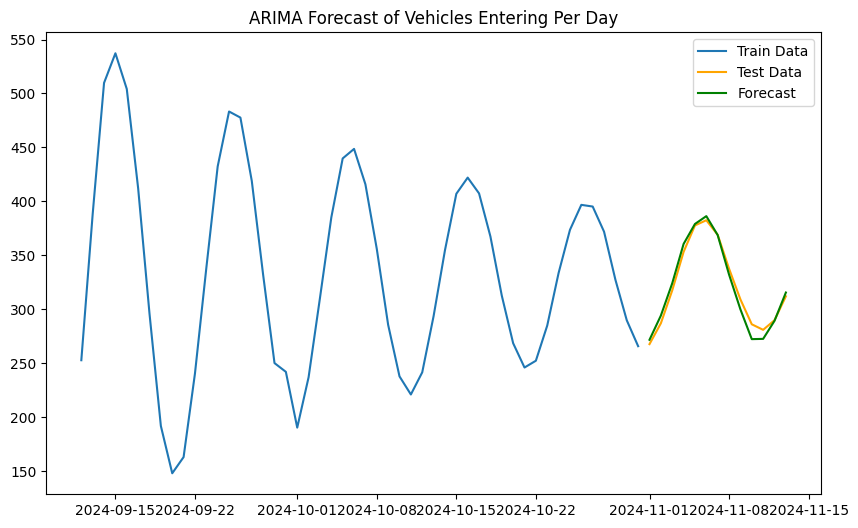

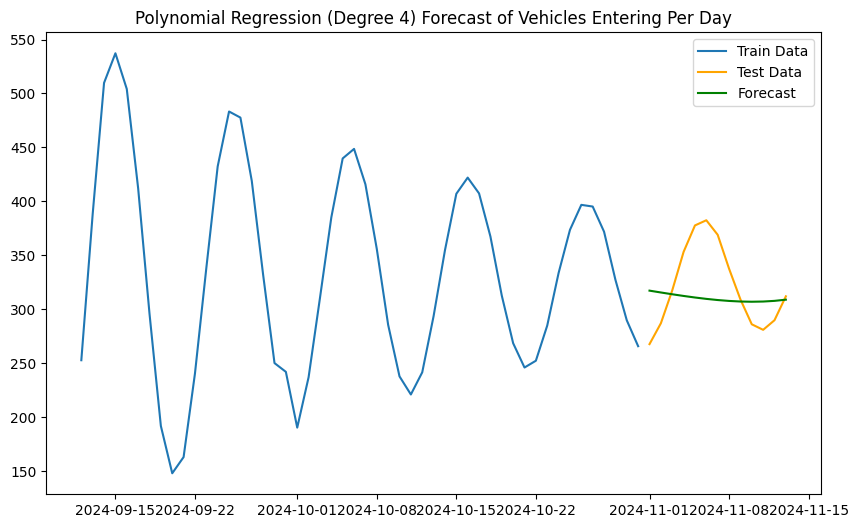

Part A: Forecast Total Number of Vehicles Entering Per Day
ARIMA MASE: 0.11024161891781759
ARIMA MAPE: 1.7934011201911424
Polynomial Regression (Degree 4) MASE: 0.6512305601709547
Polynomial Regression (Degree 4) MAPE: 9.810160295507528


In [28]:

# ARIMA model for forecasting vehicles entering
# By observation their is a peak in PACF for lag = 2 , so p = 2 , same peak in ACF for lag =1 , so q = 1 , and d = 0 as the data is already stationary, after accounting for seasonality of period 10
arima_model = ARIMA(train_data, order=(best_p,best_d,best_q) , seasonal_order=(0,1,0,5))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))

# Polynomial Regression for forecasting vehicles entering
degree = 4  # You can change the degree of the polynomial
X_train = np.arange(len(train_data)).reshape(-1, 1)
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, train_data)
poly_forecast = poly_model.predict(X_test)

# Plot ARIMA forecast
plot_series(train_data, test_data, arima_forecast, "ARIMA Forecast of Vehicles Entering Per Day")

# Plot Polynomial Regression forecast
plot_series(train_data, test_data, poly_forecast, f"Polynomial Regression (Degree {degree}) Forecast of Vehicles Entering Per Day")

# Evaluate models for Part A
print("Part A: Forecast Total Number of Vehicles Entering Per Day")
print("ARIMA MASE:", mase(test_data, arima_forecast, train_data))
print("ARIMA MAPE:", mape(test_data, arima_forecast))
print(f"Polynomial Regression (Degree {degree}) MASE:", mase(test_data, poly_forecast, train_data))
print(f"Polynomial Regression (Degree {degree}) MAPE:", mape(test_data, poly_forecast))

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:60

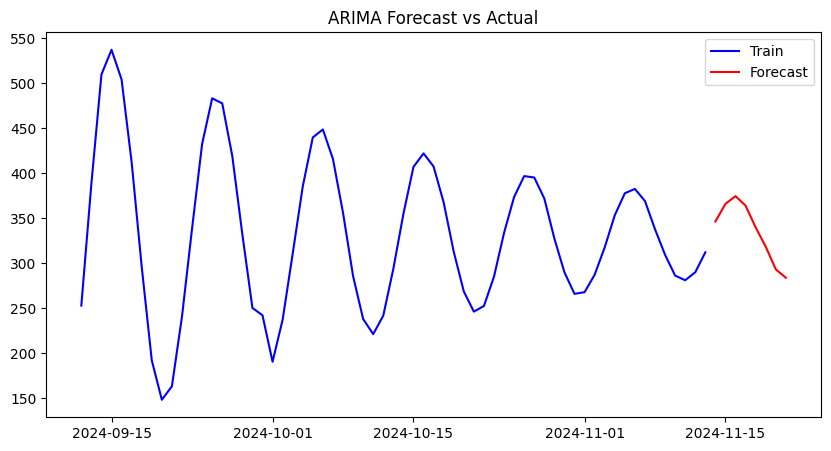

2024-11-14    346.341241
2024-11-15    365.989377
2024-11-16    374.509218
2024-11-17    363.903254
2024-11-18    339.709775
2024-11-19    318.297648
2024-11-20    293.120789
2024-11-21    283.770537
Freq: D, Name: predicted_mean, dtype: float64


In [31]:
# PLotting the forecast for 8 days , so that the forecast look continous to the actual data
model_fit = ARIMA(avg_time_per_day, order=(best_p, best_d, best_q) , seasonal_order=(0,1,0,5)).fit()
forecasted_data = plot_forecasted_Data(avg_time_per_day,7,model_fit)
print(forecasted_data)